<a href="https://colab.research.google.com/github/KangInyeong/2022AITermProject/blob/master/Team3_AITeamProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Recommendation based on Personal MBTI**

- 16102274 ParkChanwoo  
- 19102078 KangInyeong


# Contents

###Intro
<ol type = "I"> 
<li> Motivation & Problem Statement</li>
<li> Datasets</li> </ol>

###Project
<ol type = "I">
<li>Part 1. Modeling for Predicting Sentiment from Movie Reviews </li>
- EDA & Preprocessing <br>
- Trials & Choices  <br>
- Final Result  <br>
- Analysis 
</br>
<li>Part 2. Emotion Detection </li>
- EDA & Preprocessing <br>
- Trials & Choices  <br>
- Final Result  <br>
- Analysis
</br>
<li>Part 3. Movie Recommendation </li>
- Process  <br>
- Final Result  <br>
- Analysis
</ol>



## Motivation & Problem Statement
 
- Recently, Natural Language Processing has received a lot of attention in the AI field. In particular, it is appropriately used in many industries to recommend products or services through various forms of language information written by people. This is directly related to financial interests, and many studies are being conducted 
for higher accuracy and improvement.
The subject of MBTI has recently attracted attention from many people in that it can understand individual characteristics. In addition, various services are provided in a personalized recommendation method based on data. And there are so many existing movie contents that people worry about what kind of movies will be fun. With this in mind, we tried to create an application that recommends movies according to MBTI, which can be said to be an individual's representative characteristic, inspired by YouTube's video recommendation service

## Datasets

Kaggle을 연동하여 진행.
3개의 데이터셋 사용
1. (MBTI) Myers-Briggs Personality Type Dataset (8600 person’s data)
2. IMDB Dataset of 50K Movie Reviews
3. IMDb Review Dataset - ebD (more than 5.5M reviews)


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kanginyeong","key":"be86c509a094434d39275a229569b9a6"}'}

In [ ]:
#.kaggle 폴더에 kaggle.json 파일 넣기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Part1. Modeling for Predicting Sentiment from Movie Reviews

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 82% 21.0M/25.7M [00:00<00:00, 94.3MB/s]
100% 25.7M/25.7M [00:00<00:00, 94.3MB/s]


In [ ]:
!unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


### EDA & Preprocessing

In [ ]:
import pandas as pd

imdb_data = pd.read_csv('IMDB Dataset.csv')
imdb_data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
imdb_data["sentiment"]

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object

In [ ]:
imdb_data["sentiment"] = imdb_data["sentiment"].apply(lambda x: 0 if x == 'positive' else 1)
imdb_data["sentiment"]  

0        0
1        0
2        0
3        1
4        0
        ..
49995    0
49996    1
49997    1
49998    1
49999    1
Name: sentiment, Length: 50000, dtype: int64

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

sentiment_tokenizer = Tokenizer(num_words=10000)
sentiment_tokenizer.fit_on_texts(imdb_data["review"])
sequences = sentiment_tokenizer.texts_to_sequences(imdb_data["review"])
print('Found %s unique tokens.' % len(sentiment_tokenizer.word_index))

Found 124252 unique tokens.


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 100

X = pad_sequences(sequences, maxlen=max_len)
y = imdb_data["sentiment"]

In [ ]:
X_train = X[:40000]
y_train = y[:40000]

X_test = X[40000:]
y_test = y[40000:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(40000, 100) (40000,)
(10000, 100) (10000,)


In [ ]:
print('review:', X_train[0])
print('sentiment:', y_train[0])

review: [ 123  210 3241   68   14   34 1637    9   13 2239   10  413  131   10
   13 1592   15    9   18   14   10  287   51   10 1417    3 1280   15
 3184    2  189    5    1  299 2046    4 2150  570   21   39  570   18
 7658 7154 5010   26 2983   41   15    3 6904  504   20  642    2   76
  243   16    9   69 7598  651  710 6904  109  662   82 1208  693    5
   65  574    4  920 2021   38 1208  559  147 3184   22  200  426 3819
   16   48    6 3314  805 1603   43   22   67   76    8 1228   16  125
 4103  486]
sentiment: 0


In [ ]:
import numpy as np

print("Frequency of each label")
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
for unique, counts in zip(unique_elements, counts_elements):
    print("%s: %d" % (unique, counts))

Frequency of each label
0: 19993
1: 20007


### Trial1. RNN Classification Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(10000, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,088,449
Trainable params: 1,088,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('sentiment_GRU_model.h5', monitor='val_acc', mode='max', save_best_only=True)

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[es, mc])

Epoch 1/20
500/500 [==============================] - 12s 11ms/step - loss: 0.4274 - acc: 0.8006 - val_loss: 0.3795 - val_acc: 0.8316
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2815 - acc: 0.8861 - val_loss: 0.3039 - val_acc: 0.8701
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2266 - acc: 0.9099 - val_loss: 0.2993 - val_acc: 0.8777
Epoch 4/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1906 - acc: 0.9272 - val_loss: 0.3203 - val_acc: 0.8676
Epoch 5/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1633 - acc: 0.9388 - val_loss: 0.3806 - val_acc: 0.8599
Epoch 6/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1398 - acc: 0.9484 - val_loss: 0.3563 - val_acc: 0.8648
Epoch 7/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1186 - acc: 0.9574 - val_loss: 0.4138 - val_acc: 0.8591
Epoch 7: early stopping


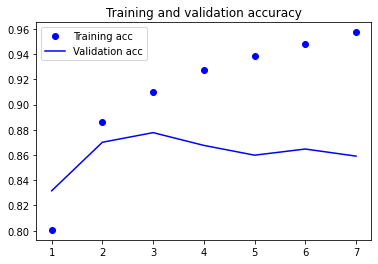

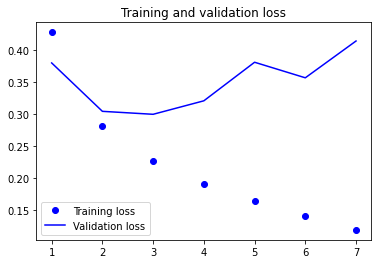

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.models import load_model

sentiment_model = load_model('sentiment_GRU_model.h5')
print("Test Accuracy: %.4f" % (sentiment_model.evaluate(X_test, y_test)[1]))

313/313 [==============================] - 2s 5ms/step - loss: 0.2938 - acc: 0.8772
Test Accuracy: 0.8772


### Trial2. CNN Classification Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense

embedding_dim = 100
dropout_ratio = 0.3
num_filters = 256
kernel_size = 3
hidden_units = 128

model = Sequential()
model.add(Embedding(10000, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 256)         77056     
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('sentiment_CNN_model1.h5', monitor='val_acc', mode='max', save_best_only=True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[es, mc])

Epoch 1/20
500/500 [==============================] - 8s 6ms/step - loss: 0.4544 - acc: 0.7693 - val_loss: 0.3164 - val_acc: 0.8650
Epoch 2/20
500/500 [==============================] - 3s 6ms/step - loss: 0.2635 - acc: 0.8931 - val_loss: 0.2989 - val_acc: 0.8727
Epoch 3/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1704 - acc: 0.9379 - val_loss: 0.3359 - val_acc: 0.8646
Epoch 4/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1041 - acc: 0.9634 - val_loss: 0.3799 - val_acc: 0.8604
Epoch 5/20
500/500 [==============================] - 3s 6ms/step - loss: 0.0596 - acc: 0.9799 - val_loss: 0.4572 - val_acc: 0.8629
Epoch 5: early stopping


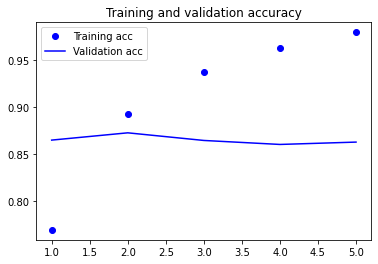

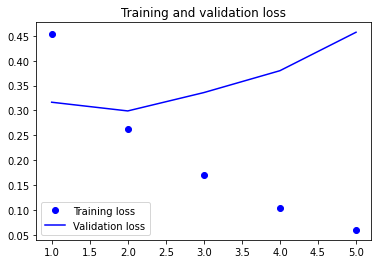

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.models import load_model

sentiment_CNN_model1 = load_model('sentiment_CNN_model1.h5')
print("Test Accuracy: %.4f" % (sentiment_CNN_model1.evaluate(X_test, y_test)[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.3051 - acc: 0.8712
Test Accuracy: 0.8712


### Trial3. Improved CNN Classification Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, BatchNormalization, GlobalMaxPooling1D, Dense

embedding_dim = 100
dropout_ratio = 0.5
num_filters = 256
kernel_size = 3
hidden_units = 128

model = Sequential()
model.add(Embedding(10000, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 dropout_2 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 256)         77056     
                                                                 
 batch_normalization (BatchN  (None, None, 256)        1024      
 ormalization)                                                   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 256)         196864    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('sentiment_CNN_model2.h5', monitor='val_acc', mode='max', save_best_only=True)
lr_anneal = ReduceLROnPlateau(monitor='val_acc', patience=5, factor=0.2, min_lr=1e-6)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train,
                    y_train,
                    epochs=20, 
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[es, mc, lr_anneal])

Epoch 1/20
500/500 [==============================] - 6s 10ms/step - loss: 0.5330 - acc: 0.7181 - val_loss: 0.4255 - val_acc: 0.8319 - lr: 0.0010
Epoch 2/20
500/500 [==============================] - 5s 9ms/step - loss: 0.3538 - acc: 0.8517 - val_loss: 0.3189 - val_acc: 0.8596 - lr: 0.0010
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2866 - acc: 0.8849 - val_loss: 0.3243 - val_acc: 0.8581 - lr: 0.0010
Epoch 4/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2379 - acc: 0.9069 - val_loss: 0.3174 - val_acc: 0.8699 - lr: 0.0010
Epoch 5/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2010 - acc: 0.9245 - val_loss: 0.3643 - val_acc: 0.8636 - lr: 0.0010
Epoch 6/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1717 - acc: 0.9359 - val_loss: 0.3905 - val_acc: 0.8599 - lr: 0.0010
Epoch 7/20
500/500 [==============================] - 5s 9ms/step - loss: 0.1444 - acc: 0.9458 - val_loss: 0.4311 - val_acc: 0

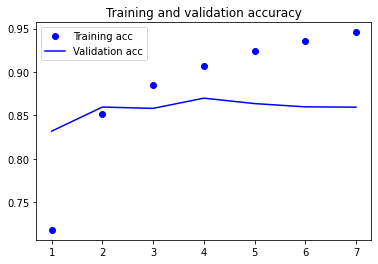

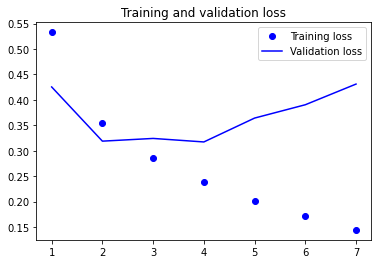

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
sentiment_CNN_model2 = load_model('sentiment_CNN_model2.h5')
print("Test Accuracy: %.4f" % (sentiment_CNN_model2.evaluate(X_test, y_test)[1]))

313/313 [==============================] - 1s 4ms/step - loss: 0.3308 - acc: 0.8643
Test Accuracy: 0.8643


### Final Result

### Analysis

## Part2. MBTI classification

In [ ]:
!kaggle datasets download -d datasnaek/mbti-type

 98% 24.0M/24.4M [00:02<00:00, 20.4MB/s]
100% 24.4M/24.4M [00:02<00:00, 11.8MB/s]


In [ ]:
!unzip mbti-type.zip

Archive:  mbti-type.zip
  inflating: mbti_1.csv              


In [ ]:
!ls

'IMDB Dataset.csv'			 part-01.json   reviews_df_result.csv
 imdb-dataset-of-50k-movie-reviews.zip	 part-02.json   sample_data
 imdb-review-dataset.zip		 part-03.json   sample.json
 kaggle.json				 part-04.json   sentiment_CNN_model1.h5
 mbti_1.csv				 part-05.json   sentiment_CNN_model2.h5
 mbti_LSTM_model_oversampling.h5	 part-06.json   sentiment_GRU_model.h5
 mbti_LSTM_model_undersampling.h5	 review_df
 mbti-type.zip				 reviews_df


In [ ]:
import pandas as pd

df = pd.read_csv("./mbti_1.csv", encoding="utf-8")
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [ ]:
df['posts'][0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [ ]:
df['posts'][0].split('|||')

["'http://www.youtube.com/watch?v=qsXHcwe3krw",
 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
 'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
 'What has been the most life-changing experience in your life?',
 'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.',
 'May the PerC Experience immerse you.',
 'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206',
 "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
 '84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-ho

### EDA & Preprocessing

In [ ]:
#Count number of users for each MBTI type
groups = df.groupby("type").count().sort_values("posts", ascending=False)
groups

,posts
type,
INFP,1832
INFJ,1470
INTP,1304
INTJ,1091
ENTP,685
ENFP,675
ISTP,337
ISFP,271
ENTJ,231


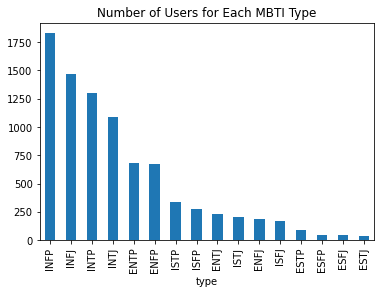

In [ ]:
groups["posts"].plot(kind="bar", title="Number of Users for Each MBTI Type")

In [ ]:
#Count number of posts for each user
num_posts = df["posts"].apply(lambda x: len(x.split("|||")))

print("Number of users:", len(df))
print("Total number of posts:", sum(num_posts))
print("Average number of posts per user:", sum(num_posts)//len(df))

Number of users: 8675
Total number of posts: 422845
Average number of posts per user: 48


In [ ]:
#Split posts
def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
df.apply(lambda x: extract(x, posts), axis=1)

df = pd.DataFrame(posts, columns=["type", "post"])
df

,type,post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...
...,...,...
422840,INFP,I was going to close my facebook a few months ...
422841,INFP,30 Seconds to Mars - All of my collections. It...
422842,INFP,"I have seen it, and i agree. I did actually th..."
422843,INFP,Ok so i have just watched Underworld 4 (Awaken...


In [ ]:
import re

#Remove links 
df["post"] = df["post"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))

#To lower
df["post"] = df["post"].apply(lambda x: x.lower())

#Keep EOS
df["post"] = df["post"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
df["post"] = df["post"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
df["post"] = df["post"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))

#Strip Punctation
df["post"] = df["post"].apply(lambda x: re.sub(r'[^\w\s]', '', x))

#Remove Non-words
df["post"] = df["post"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

#Remove multiple letter repating words
df["post"] = df["post"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*', '', x)) 

#Remove short/long words
df["post"] = df["post"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b', '', x)) 
df["post"] = df["post"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b', '', x))

#Remove words of MBTI types
#This is crutial in order to get valid model accuracy estimation for unseen data. 
mbti_types = ['INFP', 'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'ENTJ', 'ISTJ', 'ENFJ', 'ISFJ', 'ESTP', 'ESFP', 'ESFJ', 'ESTJ']
mbti_types = [mbti_type.lower() for mbti_type in mbti_types]
p = re.compile("(" + "|".join(mbti_types) + ")")
df["post"] = df["post"].apply(lambda x: p.sub(' MBTITypesToken ', x))

df

,type,post
0,INFJ,
1,INFJ,
2,INFJ,MBTITypesToken MBTITypesToken moments s...
3,INFJ,what been most lifechanging experience your...
4,INFJ,repeat most today EOSTokenDot
...,...,...
422840,INFP,going close facebook months back well ...
422841,INFP,seconds mars collections EOSTokenDot s...
422842,INFP,have seen agree EOSTokenDot actually th...
422843,INFP,have just watched underworld awakening mu...


In [ ]:
df["num_words"] = df["post"].apply(lambda x: len(re.findall(r'\w+', x)))
df["len_post"] = df["post"].apply(len)
df

,type,post,num_words,len_post
0,INFJ,,0,3
1,INFJ,,0,3
2,INFJ,MBTITypesToken MBTITypesToken moments s...,6,79
3,INFJ,what been most lifechanging experience your...,8,70
4,INFJ,repeat most today EOSTokenDot,4,40
...,...,...,...,...
422840,INFP,going close facebook months back well ...,21,187
422841,INFP,seconds mars collections EOSTokenDot s...,9,90
422842,INFP,have seen agree EOSTokenDot actually th...,28,217
422843,INFP,have just watched underworld awakening mu...,23,200


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Number of Words')

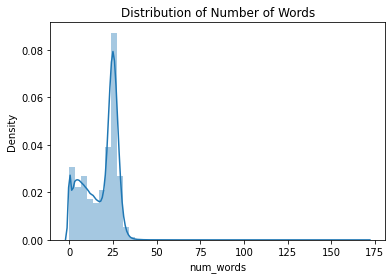

In [ ]:
import seaborn as sns

sns.distplot(df["num_words"]).set_title("Distribution of Number of Words")

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Length of Post')

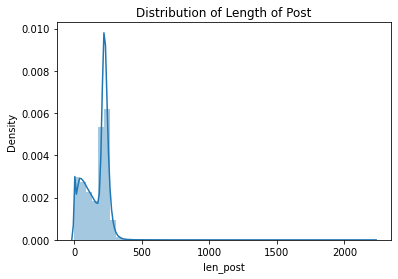

In [ ]:
sns.distplot(df["len_post"]).set_title("Distribution of Length of Post")

In [ ]:
#Remove posts with less than 15 words
print("Number of posts")

print("Before:", len(df))

min_words = 15
df = df[df["num_words"] >= min_words]

print("After:", len(df)) 

Number of posts
Before: 422845
After: 275034


In [ ]:
#Remove posts longer than 350 characters
print("Number of posts")

print("Before:", len(df))

max_len_characters = 350
df = df[df["len_post"] <= max_len_characters]

print("After:", len(df)) 

Number of posts
Before: 275034
After: 273881


In [ ]:
df = df.reset_index(drop=True)
df

,type,post,num_words,len_post
0,INFJ,hello MBTITypesToken EOSTokenDot sorry hea...,25,243
1,INFJ,prozac wellbrutin least thirty minutes movin...,27,216
2,INFJ,basically come with three items youve determi...,28,213
3,INFJ,things moderation EOSTokenDot sims indeed...,23,213
4,INFJ,dear MBTITypesToken what were your favorite...,17,133
...,...,...,...,...
273876,INFP,tonight outside window blackness night s...,29,256
273877,INFP,going close facebook months back well ...,21,187
273878,INFP,have seen agree EOSTokenDot actually th...,28,217
273879,INFP,have just watched underworld awakening mu...,23,200


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Number of Words')

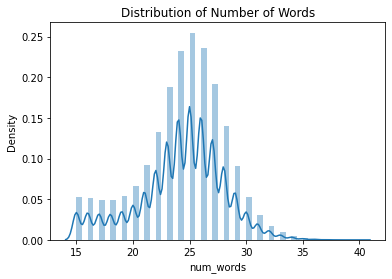

In [ ]:
sns.distplot(df["num_words"]).set_title("Distribution of Number of Words")

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Length of Post')

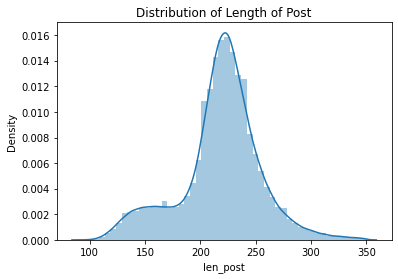

In [ ]:
sns.distplot(df["len_post"]).set_title("Distribution of Length of Post")

In [ ]:
#Drop num_words, len_post
df = df.drop(["num_words", "len_post"], axis=1)
df

,type,post
0,INFJ,hello MBTITypesToken EOSTokenDot sorry hea...
1,INFJ,prozac wellbrutin least thirty minutes movin...
2,INFJ,basically come with three items youve determi...
3,INFJ,things moderation EOSTokenDot sims indeed...
4,INFJ,dear MBTITypesToken what were your favorite...
...,...,...
273876,INFP,tonight outside window blackness night s...
273877,INFP,going close facebook months back well ...
273878,INFP,have seen agree EOSTokenDot actually th...
273879,INFP,have just watched underworld awakening mu...


In [ ]:
#Count number of posts for each MBTI type
groups = df.groupby("type").count().sort_values("post", ascending=False)
groups

,post
type,
INFP,58615
INFJ,48868
INTP,40551
INTJ,33927
ENFP,21541
ENTP,21016
ISTP,9993
ISFP,7774
ENTJ,7306


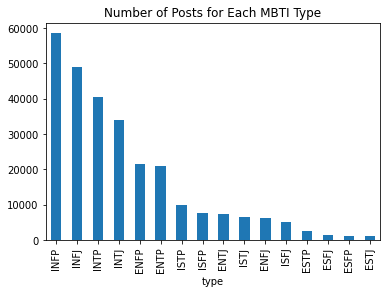

In [ ]:
groups["post"].plot(kind="bar", title="Number of Posts for Each MBTI Type")

In [ ]:
from keras.preprocessing.text import Tokenizer

#Tokenize words
mbti_tokenizer = Tokenizer(num_words=10000)
mbti_tokenizer.fit_on_texts(df["post"])
sequences = mbti_tokenizer.texts_to_sequences(df["post"])
print('Found %s unique tokens.' % len(mbti_tokenizer.word_index))

Found 104199 unique tokens.


In [ ]:
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

X = pad_sequences(sequences, maxlen=50)

le = LabelEncoder()
y = le.fit_transform(df["type"])

ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(y.reshape(-1, 1))

In [ ]:
from sklearn.model_selection import train_test_split

#Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Split train/val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

### Trial1. LSTM Classification Model with Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

def under_sampling(X, y): # Caution: Use only for training set, not for validation set or test set 
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

X_train, y_train = under_sampling(X_train, y_train)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

embedding_dim = 50
lstm_size = 32

model = Sequential()
model.add(Embedding(10000, embedding_dim))
model.add(LSTM(lstm_size))
model.add(Dense(16, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 50)          500000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                10624     
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
Total params: 511,152
Trainable params: 511,152
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('mbti_LSTM_model_undersampling.h5', monitor='val_acc', mode='max', save_best_only=True)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[es, mc])

Epoch 1/20
384/384 [==============================] - 9s 18ms/step - loss: 2.7728 - acc: 0.0613 - val_loss: 2.7791 - val_acc: 0.0512
Epoch 2/20
384/384 [==============================] - 6s 17ms/step - loss: 2.7187 - acc: 0.1177 - val_loss: 2.7407 - val_acc: 0.0948
Epoch 3/20
384/384 [==============================] - 7s 20ms/step - loss: 2.4125 - acc: 0.2377 - val_loss: 3.0023 - val_acc: 0.0565
Epoch 4/20
384/384 [==============================] - 7s 19ms/step - loss: 1.9416 - acc: 0.3944 - val_loss: 3.2543 - val_acc: 0.0667
Epoch 5/20
384/384 [==============================] - 7s 19ms/step - loss: 1.5121 - acc: 0.5402 - val_loss: 3.7704 - val_acc: 0.0690
Epoch 6/20
384/384 [==============================] - 8s 20ms/step - loss: 1.1860 - acc: 0.6503 - val_loss: 4.2508 - val_acc: 0.0687
Epoch 7/20
384/384 [==============================] - 7s 19ms/step - loss: 0.9265 - acc: 0.7317 - val_loss: 4.8849 - val_acc: 0.0592
Epoch 7: early stopping


In [ ]:
from tensorflow.keras.models import load_model

mbti_LSTM_model_undersampling = load_model('mbti_LSTM_model_undersampling.h5')
print("Test Accuracy: %.4f" % (mbti_LSTM_model_undersampling.evaluate(X_test, y_test)[1]))

1712/1712 [==============================] - 7s 4ms/step - loss: 2.7383 - acc: 0.0966
Test Accuracy: 0.0966


### Trial2. LSTM Classification Model with Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

def over_sampling(X, y): # Caution: Use only for training set, not for validation set or test set
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    return X_resampled, y_resampled

X_train, y_train = over_sampling(X_train, y_train)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('mbti_LSTM_model_oversampling.h5', monitor='val_acc', mode='max', save_best_only=True)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[es, mc])

Epoch 1/20
384/384 [==============================] - 9s 19ms/step - loss: 0.8043 - acc: 0.7730 - val_loss: 4.9457 - val_acc: 0.0736
Epoch 2/20
384/384 [==============================] - 8s 21ms/step - loss: 0.6211 - acc: 0.8272 - val_loss: 5.3508 - val_acc: 0.0716
Epoch 3/20
384/384 [==============================] - 7s 19ms/step - loss: 0.5081 - acc: 0.8585 - val_loss: 5.9994 - val_acc: 0.0660
Epoch 4/20
384/384 [==============================] - 7s 19ms/step - loss: 0.4251 - acc: 0.8841 - val_loss: 6.1408 - val_acc: 0.0738
Epoch 5/20
384/384 [==============================] - 6s 17ms/step - loss: 0.3503 - acc: 0.9026 - val_loss: 6.6494 - val_acc: 0.0694
Epoch 6/20
384/384 [==============================] - 7s 19ms/step - loss: 0.2910 - acc: 0.9226 - val_loss: 6.8332 - val_acc: 0.0706
Epoch 6: early stopping


In [ ]:
from tensorflow.keras.models import load_model

mbti_LSTM_model_oversampling = load_model('mbti_LSTM_model_oversampling.h5')
print("\nTest Accuracy: %.4f" % (mbti_LSTM_model_oversampling.evaluate(X_test, y_test)[1]))

1712/1712 [==============================] - 7s 4ms/step - loss: 6.1484 - acc: 0.0732

Test Accuracy: 0.0732


### Final Result

In [ ]:
final_mbti_model = load_model('mbti_LSTM_model_undersampling.h5')
predicted = final_mbti_model.predict(X_test)
predicted

1712/1712 [==============================] - 5s 3ms/step


array([[0.05452379, 0.07657839, 0.04774225, ..., 0.06005333, 0.05536855,
        0.05334323],
       [0.04441745, 0.03655389, 0.06316379, ..., 0.07281461, 0.03348142,
        0.08838011],
       [0.04346254, 0.02799654, 0.0693602 , ..., 0.07114118, 0.02539865,
        0.09062715],
       ...,
       [0.05164853, 0.04624741, 0.0731692 , ..., 0.05918363, 0.05472137,
        0.08104223],
       [0.07617901, 0.07777189, 0.03257833, ..., 0.09660548, 0.04598475,
        0.0408029 ],
       [0.1070721 , 0.04552806, 0.0822241 , ..., 0.04475183, 0.07509574,
        0.04858366]], dtype=float32)

In [ ]:
predicted[0]

array([0.05452379, 0.07657839, 0.04774225, 0.05303985, 0.10213175,
       0.09458893, 0.07378028, 0.08501372, 0.04953063, 0.03746582,
       0.05121721, 0.04160921, 0.06401312, 0.06005333, 0.05536855,
       0.05334323], dtype=float32)

In [ ]:
import numpy as np

predicted_label = np.argmax(predicted, axis=1)
predicted_label = le.inverse_transform(predicted_label)

actual_label = ohe.inverse_transform(y_test).reshape(-1)
actual_label = le.inverse_transform(actual_label)

In [ ]:
result_df = pd.DataFrame()
result_df["actual"] = pd.Series(actual_label)
result_df["predicted"] = pd.Series(predicted_label)
result_df

,actual,predicted
0,INFP,ESFJ
1,INFP,ISTP
2,ISFJ,ESFJ
3,ISTP,ESFJ
4,ENFJ,ESFJ
...,...,...
54772,ISFJ,INFJ
54773,ENFP,ISFP
54774,INFP,ENTP
54775,ENFP,ESFJ


In [ ]:
result_df["1st_letter_hit"] = result_df["actual"].apply(lambda x: x[0]) == result_df["predicted"].apply(lambda x: x[0])
result_df["2nd_letter_hit"] = result_df["actual"].apply(lambda x: x[1]) == result_df["predicted"].apply(lambda x: x[1])
result_df["3rd_letter_hit"] = result_df["actual"].apply(lambda x: x[2]) == result_df["predicted"].apply(lambda x: x[2])
result_df["4th_letter_hit"] = result_df["actual"].apply(lambda x: x[3]) == result_df["predicted"].apply(lambda x: x[3])
result_df

,actual,predicted,1st_letter_hit,2nd_letter_hit,3rd_letter_hit,4th_letter_hit
0,INFP,ESFJ,False,False,True,False
1,INFP,ISTP,True,False,False,True
2,ISFJ,ESFJ,False,True,True,True
3,ISTP,ESFJ,False,True,False,False
4,ENFJ,ESFJ,True,False,True,True
...,...,...,...,...,...,...
54772,ISFJ,INFJ,True,False,True,True
54773,ENFP,ISFP,False,False,True,True
54774,INFP,ENTP,False,True,False,True
54775,ENFP,ESFJ,True,False,True,False


In [ ]:
print("1st letter accuracy (E vs I):", result_df["1st_letter_hit"].mean())
print("2nd letter accuracy (S vs N):", result_df["2nd_letter_hit"].mean())
print("3rd letter accuracy (F vs T):", result_df["3rd_letter_hit"].mean())
print("4th letter accuracy (J vs P):", result_df["4th_letter_hit"].mean())

1st letter accuracy (E vs I): 0.5581904814064297
2nd letter accuracy (S vs N): 0.5160560089088486
3rd letter accuracy (F vs T): 0.5573872245650546
4th letter accuracy (J vs P): 0.5268817204301075


### Analysis

## Part3. Movie Recommendation

In [ ]:
!kaggle datasets download -d ebiswas/imdb-review-dataset

100% 2.69G/2.69G [02:10<00:00, 18.5MB/s]
100% 2.69G/2.69G [02:10<00:00, 22.2MB/s]


In [ ]:
!unzip imdb-review-dataset.zip

Archive:  imdb-review-dataset.zip
  inflating: part-01.json            
  inflating: part-02.json            
  inflating: part-03.json            
  inflating: part-04.json            
  inflating: part-05.json            
  inflating: part-06.json            
  inflating: sample.json             


In [ ]:
!ls

'IMDB Dataset.csv'			 part-01.json   reviews_df_result.csv
 imdb-dataset-of-50k-movie-reviews.zip	 part-02.json   sample_data
 imdb-review-dataset.zip		 part-03.json   sample.json
 kaggle.json				 part-04.json   sentiment_CNN_model1.h5
 mbti_1.csv				 part-05.json   sentiment_CNN_model2.h5
 mbti_LSTM_model_oversampling.h5	 part-06.json   sentiment_GRU_model.h5
 mbti_LSTM_model_undersampling.h5	 review_df
 mbti-type.zip				 reviews_df


In [ ]:
import time
import json
import pandas as pd

# Load data into dataframe
dataDir = "./" 
files_to_load = ["part-01.json", "part-02.json", "part-03.json"] # 3개 넘어가면 메모리 초과

reviews_df = pd.DataFrame()

reviews_json = list()
startTime = time.time()
for current_file in files_to_load:
    print(f"Starting load of {current_file}...")
    with open(f"{dataDir}/{current_file}", mode='r') as file:
        new_reviews = json.load(file)
        for review in new_reviews:
            reviews_json.append(review)

        new_df = pd.DataFrame(reviews_json)[["movie", "review_detail"]]
        reviews_df = pd.concat([reviews_df, new_df])

    print(f"Finished load of {current_file} at {time.time() - startTime:.2f} total seconds elapsed.")
    reviews_json = list()

print(f"Loading complete after {time.time() - startTime:.2f} seconds.")

Starting load of part-01.json...
Finished load of part-01.json at 15.91 total seconds elapsed.
Starting load of part-02.json...
Finished load of part-02.json at 34.80 total seconds elapsed.
Starting load of part-03.json...
Finished load of part-03.json at 57.07 total seconds elapsed.
Loading complete after 57.07 seconds.


In [ ]:
reviews_df = reviews_df.reset_index(drop=True)
reviews_df

,movie,review_detail
0,After Life (2019– ),"I enjoyed the first season, but I must say I t..."
1,The Valhalla Murders (2019– ),I know Iceland is a small country and police d...
2,Special OPS (2020– ),"Except K K , no other actor looks comfortable ..."
3,#BlackAF (2020– ),I'm guessing that as a 62 year old white woman...
4,The Droving (2020),Here's the truth. There's not much to this mov...
...,...,...
3037500,The Insider (1999),"This is an absolute magnificent movie, in fact..."
3037501,The Insider (1999),There are times that The Insider will leave yo...
3037502,The Insider (1999),The sense of scandal and coverup is in the air...
3037503,The Insider (1999),"""The Insider"" is the latest from ""Vegas"" and ""..."


In [ ]:
reviews_df.to_csv("reviews_df", index_label="index")

In [ ]:
import pandas as pd

reviews_df = pd.read_csv("reviews_df", index_col="index")

In [ ]:
reviews_df

,movie,review_detail
index,,
0,After Life (2019– ),"I enjoyed the first season, but I must say I t..."
1,The Valhalla Murders (2019– ),I know Iceland is a small country and police d...
2,Special OPS (2020– ),"Except K K , no other actor looks comfortable ..."
3,#BlackAF (2020– ),I'm guessing that as a 62 year old white woman...
4,The Droving (2020),Here's the truth. There's not much to this mov...
...,...,...
3037500,The Insider (1999),"This is an absolute magnificent movie, in fact..."
3037501,The Insider (1999),There are times that The Insider will leave yo...
3037502,The Insider (1999),The sense of scandal and coverup is in the air...


In [ ]:
print("Number of movies:", len(set(reviews_df['movie'])))

Number of movies: 327979


In [ ]:
#Sort movies by count in descending order
movie_counts_df = reviews_df.groupby('movie').size().reset_index(name='count').sort_values('count', ascending=False)
movie_counts_df

,movie,count
23742,Avengers: Endgame (2019),8771
69403,Dil Bechara (2020),7764
94335,Game of Thrones: The Iron Throne (2019) Season...,7428
312716,Wonder Woman 1984 (2020),6810
320769,小丑 (2019),6514
...,...,...
145703,Les petits meurtres d'Agatha Christie: Am stra...,1
145705,Les petits meurtres d'Agatha Christie: Crimes ...,1
145706,Les petits meurtres d'Agatha Christie: Ding Di...,1
145707,Les petits meurtres d'Agatha Christie: Drame e...,1


In [ ]:
#Remove movies with fewer than 300 review
movie_counts_df = movie_counts_df[movie_counts_df['count'] >= 300]
movie_counts_df

,movie,count
23742,Avengers: Endgame (2019),8771
69403,Dil Bechara (2020),7764
94335,Game of Thrones: The Iron Throne (2019) Season...,7428
312716,Wonder Woman 1984 (2020),6810
320769,小丑 (2019),6514
...,...,...
216440,Sex and the City 2 (2010),300
306983,Watchmen (2009),300
263278,The Ladykillers (2004),300
317659,Zombieland (2009),300


In [ ]:
reviews_df = reviews_df[reviews_df['movie'].isin(movie_counts_df['movie'])]
reviews_df = reviews_df.reset_index(drop=True)
reviews_df

,movie,review_detail
0,After Life (2019– ),"I enjoyed the first season, but I must say I t..."
1,Special OPS (2020– ),"Except K K , no other actor looks comfortable ..."
2,Iron Fist (2017–2018),I loved it from the first episode! And I could...
3,This Is Us (2016– ),This is the show for people for whom nothing e...
4,Unstoppable (2010),A suspenseful thrilling adventure about a loos...
...,...,...
965399,Training Day (2001),"Training Day, in my eyes, did not meet the hyp..."
965400,Training Day (2001),Denzel was totally over-rated as a corrupt cop...
965401,Training Day (2001),"Denzel is one of my favorite actors, and yes I..."
965402,Training Day (2001),Before watching the movie I had read some good...


### Process1) Sentiment Information

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences = sentiment_tokenizer.texts_to_sequences(reviews_df['review_detail'])
sequences = pad_sequences(sequences, maxlen=100)
sequences

array([[   0,    0,    0, ...,  244,  888,  202],
       [   0,    0,    0, ...,    2,  111,    6],
       [   0,    0,    0, ..., 1923, 1906, 1174],
       ...,
       [   0,    0,    0, ...,   80,   26, 4167],
       [4000,   80,   28, ...,  120,  226,   51],
       [   5,   63,    3, ...,    3, 2718, 2650]], dtype=int32)

In [ ]:
from tensorflow.keras.models import load_model

final_sentiment_model = load_model('sentiment_CNN_model2.h5')

sentiment_score = final_sentiment_model.predict(sequences).reshape(-1)

30169/30169 [==============================] - 66s 2ms/step


In [ ]:
sentiment_score = pd.Series(sentiment_score)
sentiment_score

0         0.006074
1         0.628968
2         0.137964
3         0.994608
4         0.000468
            ...   
965399    0.658152
965400    0.470543
965401    0.232750
965402    0.002361
965403    0.826967
Length: 965404, dtype: float32

In [ ]:
reviews_df['sentiment'] = sentiment_score.apply(lambda x: "positive" if x > 0.5 else "negative")
reviews_df

,movie,review_detail,sentiment
0,After Life (2019– ),"I enjoyed the first season, but I must say I t...",negative
1,Special OPS (2020– ),"Except K K , no other actor looks comfortable ...",positive
2,Iron Fist (2017–2018),I loved it from the first episode! And I could...,negative
3,This Is Us (2016– ),This is the show for people for whom nothing e...,positive
4,Unstoppable (2010),A suspenseful thrilling adventure about a loos...,negative
...,...,...,...
965399,Training Day (2001),"Training Day, in my eyes, did not meet the hyp...",positive
965400,Training Day (2001),Denzel was totally over-rated as a corrupt cop...,negative
965401,Training Day (2001),"Denzel is one of my favorite actors, and yes I...",negative
965402,Training Day (2001),Before watching the movie I had read some good...,negative


### Process2) MBTI Information

In [ ]:
sequences = mbti_tokenizer.texts_to_sequences(reviews_df['review_detail'])
sequences = pad_sequences(sequences, maxlen=50)
sequences

array([[   0,    0,    0, ...,  294,  264, 2873],
       [   0,    0,    0, ..., 2867,  294, 2107],
       [   0,    0,    0, ..., 1423, 2217, 2051],
       ...,
       [   0,    0,    0, ...,    2,   42, 2628],
       [  27,   27, 1129, ...,   47,  105,   21],
       [   0,    0,    0, ...,    9, 3957, 2483]], dtype=int32)

In [ ]:
from tensorflow.keras.models import load_model

final_mbti_model = load_model('mbti_LSTM_model_undersampling.h5')

In [ ]:
predicted = final_mbti_model.predict(sequences)
predicted

30169/30169 [==============================] - 79s 3ms/step


array([[0.04310756, 0.06144223, 0.054295  , ..., 0.06376484, 0.04683208,
        0.07537739],
       [0.05191561, 0.06358624, 0.05464128, ..., 0.07915726, 0.06265903,
        0.07085221],
       [0.08238479, 0.05407641, 0.0657243 , ..., 0.05856103, 0.06892589,
        0.06253822],
       ...,
       [0.05407853, 0.05001237, 0.07672904, ..., 0.0599934 , 0.05825724,
        0.0765468 ],
       [0.06017306, 0.03792135, 0.09532574, ..., 0.05247639, 0.04918082,
        0.07452127],
       [0.0381155 , 0.04849527, 0.05478837, ..., 0.07691473, 0.03930507,
        0.07933307]], dtype=float32)

In [ ]:
predicted[0]

array([0.04310756, 0.06144223, 0.054295  , 0.04743971, 0.08928771,
       0.07596656, 0.07211775, 0.10200182, 0.05901416, 0.04465416,
       0.06255312, 0.05070998, 0.05143591, 0.06376484, 0.04683208,
       0.07537739], dtype=float32)

In [ ]:
import numpy as np

predicted_label = np.argmax(predicted, axis=1)
predicted_label = le.inverse_transform(predicted_label)
predicted_label

array(['ESTP', 'INFP', 'INTJ', ..., 'INTP', 'INTP', 'ISFJ'], dtype=object)

In [ ]:
reviews_df["MBTI"] = pd.Series(predicted_label)
reviews_df

,movie,review_detail,sentiment,MBTI
0,After Life (2019– ),"I enjoyed the first season, but I must say I t...",negative,ESTP
1,Special OPS (2020– ),"Except K K , no other actor looks comfortable ...",positive,INFP
2,Iron Fist (2017–2018),I loved it from the first episode! And I could...,negative,INTJ
3,This Is Us (2016– ),This is the show for people for whom nothing e...,positive,INFP
4,Unstoppable (2010),A suspenseful thrilling adventure about a loos...,negative,INFJ
...,...,...,...,...
965399,Training Day (2001),"Training Day, in my eyes, did not meet the hyp...",positive,ESTP
965400,Training Day (2001),Denzel was totally over-rated as a corrupt cop...,negative,ISTP
965401,Training Day (2001),"Denzel is one of my favorite actors, and yes I...",negative,INTP
965402,Training Day (2001),Before watching the movie I had read some good...,negative,INTP


In [ ]:
reviews_df.to_csv("reviews_df_result.csv", index_label="index")

### Final Result
Assumption) Jessica is "ESFJ" and wants to get movie recommendation.

In [ ]:
# def movie_recommender(own_mbti):
#   if reviews_df['sentiment'] == 'positive' and reviews_df['review_mbti'] == own_mbti:
#     print(reviews_df['movie'])

In [ ]:
import pandas as pd

reviews_df = pd.read_csv("reviews_df_result.csv", index_col="index")
reviews_df

,movie,review_detail,sentiment,MBTI
index,,,,
0,After Life (2019– ),"I enjoyed the first season, but I must say I t...",negative,ESTP
1,Special OPS (2020– ),"Except K K , no other actor looks comfortable ...",positive,INFP
2,Iron Fist (2017–2018),I loved it from the first episode! And I could...,negative,INTJ
3,This Is Us (2016– ),This is the show for people for whom nothing e...,positive,INFP
4,Unstoppable (2010),A suspenseful thrilling adventure about a loos...,negative,INFJ
...,...,...,...,...
965399,Training Day (2001),"Training Day, in my eyes, did not meet the hyp...",positive,ESTP
965400,Training Day (2001),Denzel was totally over-rated as a corrupt cop...,negative,ISTP
965401,Training Day (2001),"Denzel is one of my favorite actors, and yes I...",negative,INTP


In [ ]:
reviews_df["is_positive"] = reviews_df["sentiment"].apply(lambda x: True if x == "positive" else False)
reviews_df

,movie,review_detail,sentiment,MBTI,is_positive
index,,,,,
0,After Life (2019– ),"I enjoyed the first season, but I must say I t...",negative,ESTP,False
1,Special OPS (2020– ),"Except K K , no other actor looks comfortable ...",positive,INFP,True
2,Iron Fist (2017–2018),I loved it from the first episode! And I could...,negative,INTJ,False
3,This Is Us (2016– ),This is the show for people for whom nothing e...,positive,INFP,True
4,Unstoppable (2010),A suspenseful thrilling adventure about a loos...,negative,INFJ,False
...,...,...,...,...,...
965399,Training Day (2001),"Training Day, in my eyes, did not meet the hyp...",positive,ESTP,True
965400,Training Day (2001),Denzel was totally over-rated as a corrupt cop...,negative,ISTP,False
965401,Training Day (2001),"Denzel is one of my favorite actors, and yes I...",negative,INTP,False


In [ ]:
# 각 MBTI의 각 movie에 대한 positive 비율
reviews_df.groupby(["MBTI", "movie"]).mean()

is_positive
MBTI movie                                  
ENFJ #Alive (2020)                  0.500000
     007：空降危機 (2012)                0.275862
     00:30凌晨密令 (2012)               0.125000
     10 Cloverfield Lane (2016)     0.125000
     10,000 BC (2008)               1.000000
...                                      ...
ISTP 鋒迴路轉 (2019)                    0.232143
     雙子殺手 (2019)                    0.511628
     雲圖 (2012)                      0.444444
     鬼影特攻：以暴制暴 (2019)               0.612565
     黑暗騎士：黎明昇起 (2012)               0.594595

[21363 rows x 1 columns]

In [ ]:
#각 MBTI의 각 movie별로 리뷰가 25개 이상이면서 positive 비율이 90% 이상인 것 집계
reviews_df.groupby(["MBTI", "movie"]).filter(lambda x: x["is_positive"].count() >= 25 and x["is_positive"].mean() >= 0.9).groupby(["MBTI", "movie"]).mean()

is_positive
MBTI movie                                               
ENFP Hard Kill (2020)                            0.965517
     The War of the Worlds (2019)                0.940000
ESTJ Coolie No. 1 (2020)                         0.929577
     Laxmii (2020)                               0.911765
     Sadak 2 (2020)                              0.952381
     The Last Airbender (2010)                   0.906977
     The Witches (2020)                          0.920000
ESTP Baaghi 3 (2020)                             0.911111
     Disaster Movie (2008)                       0.918367
     Hanum & Rangga: Faith & The City (2018)     0.920000
     Hard Kill (2020)                            0.974359
     Student of the Year 2 (2019)                0.921569
     Swiped (I) (2018)                           0.975610
     The 2nd (2020)                              0.960000
     The Open House (2018)                       0.925926
     Trauma Center (2019)                        0.919355
INFJ Hanum & Rangga: Faith & The City (2018)     0.961538
     Hard Kill (2020)                            0.937500
     Laxmii (2020)                               0.903683
     Swiped (I) (2018)                           0.920000
     The 2nd (2020)                              0.914286
     The Open House (2018)                       0.921875
INFP Hard Kill (2020)                            0.960526
     Swiped (I) (2018)                           0.942857
     The Open House (2018)                       0.912088
     Wounds (2019)                               0.900000
INTJ Coolie No. 1 (2020)                         0.925373
     The Dead Don't Die (2019)                   0.960000
INTP Hard Kill (2020)                            0.928571
     Laxmii (2020)                               0.918072
     Sadak 2 (2020)                              0.945455
     Secret Obsession (2019)                     0.934783
     Swiped (I) (2018)                           1.000000
     The Grudge (2020)                           0.961538
     The Last Days of American Crime (2020)      0.928571
     The Last Thing He Wanted (2020)             0.937500
     The Open House (2018)                       0.975000
     The Wicker Man (2006)                       0.900000
ISTJ Coolie No. 1 (2020)                         0.922619
     Hard Kill (2020)                            0.982143
     Sadak 2 (2020)                              0.913386
     Slender Man (2018)                          0.925000
     Swiped (I) (2018)                           0.961538
     The 2nd (2020)                              0.980392
ISTP Bhaag Beanie Bhaag (2020– )                 0.906977
     Black Christmas (2019)                      0.911765
     Ghost Stories (2020)                        0.923077
     Hard Kill (2020)                            0.934783
     Poltergeist (2015)                          0.918919
     Sadak 2 (2020)                              0.942029
     Swiped (I) (2018)                           1.000000
     The 2nd (2020)                              0.951613
     The Rat (II) (2019)                         0.965517
     The Turning (2020)                          0.944444
     Trauma Center (2019)                        0.918367

### Analysis

## Extra
- 관련 연구
- 레퍼런스
- Contribution
   Chanwoo: Data preprocessing   
   Inyeong: Model Training
- Debugging
- GitHub Repository